# GraphRAG with Wikipedia and GPT OSS

[txtai](https://github.com/neuml/txtai) is an all-in-one AI framework for semantic search, LLM orchestration and language model workflows.

Retrieval Augmented Generation (RAG) is one of the most popular techniques in the AI space today. RAG takes a user request, retrieves the best matching content and then plugs that context into an LLM prompt to generate an answer. When otherwise not mentioned, most assume the context is generated using a vector database query. But there is no rule that says context can't be generated with other methods. It could be a simple web query, SQL query, text index search or other traditional search.

We also often hear the term GraphRAG. GraphRAG means different things to different people. Here we're going to build an example that uses `txtai`, [wikipedia](https://huggingface.co/datasets/NeuML/wikipedia-20250620) and [gpt-oss](https://huggingface.co/openai/gpt-oss-20b) to research a specific topic with graphs. `txtai` has a built-in graph component that automatically generates a graph network over the data loaded into an embeddings database. We'll use a pre-built embeddings database hosted on the Hugging Face Hub, [txtai-wikipedia-slim](https://hf.co/neuml/txtai-wikipedia-slim).

# Install dependencies

Install `txtai` and all dependencies.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[graph,pipeline-llm]

# Load txtai-wikipedia-slim

Next, we'll load the embeddings database. This database is the top 100K most viewed Wikipedia articles with both a dense vector index and graph network enabled.

In [ ]:
from txtai import Embeddings

embeddings = Embeddings().load(provider="huggingface-hub", container="neuml/txtai-wikipedia-slim")

# Build context with a graph query

The `txtai` graph component supports the [openCypher](https://opencypher.org/) query language via the [GrandCypher](https://github.com/aplbrain/grand-cypher) library.

openCypher is a language for expressive and efficient data querying of a property graph. In this example, we'll traverse the embeddings database graph looking for paths between nodes similar to `chatgpt` and `anthropic`.

In [67]:
g = embeddings.search("""
MATCH P=(A)-[]->(B)
WHERE SIMILAR(A, 'chatgpt') AND SIMILAR(B, 'anthropic')
RETURN P
LIMIT 10
""", graph=True)

The query above is an extremely powerful combination of an vector similarity node search and a graph traversal query that walks the paths between nodes. It's much more expressive than simply saying find nodes similar to each of the concepts independently. It can be considered a `deep graph search`.

# Plot the context network

Let's show the context as a graph plot!

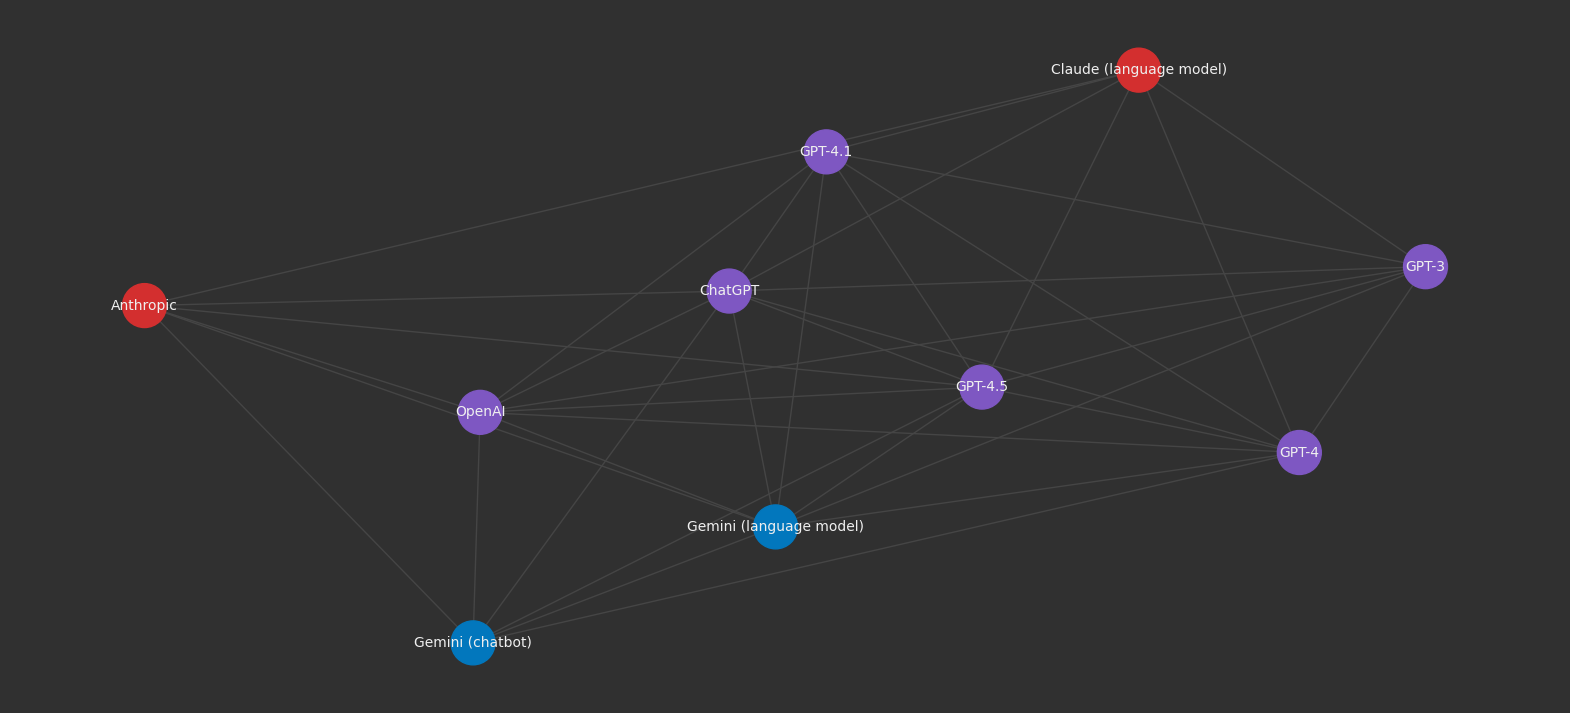

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot(graph):
    labels = {x: f"{graph.attribute(x, 'id')}" for x in graph.scan()}
    colors = ["#D32F2F", "#0277bd", "#7e57c2", "#757575"]

    results = embeddings.batchsimilarity(labels.values(), ["Anthropic Claude", "Google Gemini", "OpenAI GPT"])
    colors = [colors[x[0][0]] for x in results]

    options = {
        "node_size": 1000,
        "node_color": colors,
        "edge_color": "#454545",
        "font_color": "#efefef",
        "font_size": 10,
        "alpha": 1.0,
    }

    fig, ax = plt.subplots(figsize=(20, 9))
    pos = nx.spring_layout(graph.backend, seed=0, k=0.9, iterations=50)
    nx.draw_networkx(graph.backend, pos=pos, labels=labels, **options)
    ax.set_facecolor("#303030")
    ax.axis("off")
    fig.set_facecolor("#303030")

    plt.show()

plot(g)

# Print the context as text

Let's further inspect the graph nodes.

In [92]:
context = ""
for x in g.scan():
    uid = g.attribute(x, "id")

    context += f"- id: {uid}\n"
    context += f"  url: https://en.wikipedia.org/wiki/{uid.replace(' ', '_')}\n"
    context += f"  text: {g.attribute(x, 'text')}\n"
    context += f"  links: {[g.attribute(n, 'id') for n in g.edges(x)]}\n"

In [93]:
print(context)

- id: ChatGPT
  url: https://en.wikipedia.org/wiki/ChatGPT
  text: ChatGPT is a generative artificial intelligence chatbot developed by OpenAI and released on November 30, 2022. It uses large language models (LLMs) such as GPT-4o as well as other multimodal models to create human-like responses in text, speech, and images. It has access to features such as searching the web, using apps, and running programs. It is credited with accelerating the AI boom, an ongoing period of rapid investment in and public attention to the field of artificial intelligence (AI). Some observers have raised concern about the potential of ChatGPT and similar programs to displace human intelligence, enable plagiarism, or fuel misinformation.
  links: ['GPT-4', 'GPT-4.5', 'OpenAI', 'Gemini (chatbot)', 'GPT-3', 'GPT-4.1', 'Gemini (language model)', 'Anthropic', 'Claude (language model)']
- id: GPT-4
  url: https://en.wikipedia.org/wiki/GPT-4
  text: Generative Pre-trained Transformer 4 (GPT-4) is a multimodal l

# GraphRAG

Now that we have our graph context, we'll plug that into an LLM prompt.

In [ ]:
from txtai import LLM

llm = LLM("unsloth/gpt-oss-20b-GGUF/gpt-oss-20b-Q4_K_M.gguf", n_ctx=20000)

In [82]:
from IPython.display import display, Markdown

out = llm(f"""
Analyze the following context and write an article about it
{context}
""", defaultrole="user", maxlength=20000, stripthink=True)

display(Markdown(out))

**ChatGPT, GPT‑4, and the New Generation of Generative AI: A Timeline of Innovation and Impact**

*By [Your Name]*  
*Published: 2025‑09‑03*

---

### 1.  The Dawn of Generative AI

The field of artificial intelligence (AI) has long promised “highly autonomous systems that outperform humans at most economically valuable work.”  In practice, the most visible manifestation of that promise has been the rapid rise of large language models (LLMs) that can generate text, speech, and even images that read like they were written by a human.  The most influential of these models has come from a handful of companies—OpenAI, Google DeepMind, and Anthropic—each building a family of models that have pushed the boundaries of what machines can do.

---

### 2.  OpenAI’s GPT Series

| Model | Release | Key Features | Notes |
|-------|---------|---------------|-------|
| **GPT‑3** | 2020 | 175 billion parameters; first public GPT model | Laid the groundwork for conversational AI |
| **ChatGPT** | 2022‑11‑30 | Uses GPT‑4o and multimodal models; web‑search, app‑integration, program execution | Sparked the “AI boom” and widespread public interest |
| **GPT‑4** | 2023‑03‑14 | Multimodal; released via ChatGPT Plus, API, Microsoft Copilot | Became the de‑facto standard for LLM‑based chat |
| **GPT‑4.1** | 2025‑04‑14 | Three variants (mini, nano) released simultaneously | Improved safety and performance |
| **GPT‑4.5** | 2025‑02‑27 | Codename “Orion”; API access to be phased out in July | Highest‑performance model in the GPT line |

OpenAI’s mission—“safe and beneficial” artificial general intelligence—has guided the evolution of these models.  The company’s public releases have been accompanied by a steady stream of research papers, API documentation, and developer playgrounds that allow researchers and businesses to experiment with the models at scale.

---

### 3.  Google DeepMind’s Gemini

Google’s response to the GPT wave came in 2023 with **Gemini (chatbot)**, a generative AI chatbot that replaced the earlier Bard.  Gemini is powered by the **Gemini (language model)** family, which includes Gemini Ultra, Pro, Flash, and Nano.  The models were announced on 2023‑12‑06 and positioned as direct competitors to GPT‑4.  In March 2025, Gemini 2.5 Pro Experimental was rated as “highly competitive,” underscoring the rapid parity between the two ecosystems.

---

### 4.  Anthropic’s Claude

Founded in 2021, **Anthropic PBC** has focused on the safety properties of AI.  Their flagship LLM family, **Claude**, was first released in March 2023.  Claude is marketed as a competitor to both ChatGPT and Gemini, with a particular emphasis on “safe models for the public.”  Anthropic’s research agenda—studying safety at the technological frontier—has positioned it as a counter‑balance to the commercial focus of OpenAI and Google.

---

### 5.  The Feature Set that Changed the Game

ChatGPT’s launch was not just a new model; it was a new **feature set**:

* **Web Search** – The ability to query up‑to‑date information in real time.  
* **App Integration** – Running third‑party applications directly from the chat interface.  
* **Program Execution** – The capacity to run code snippets and return results.  

These capabilities turned a simple chatbot into a *digital assistant* that can browse, compute, and even generate images (via DALL‑E) or video (via Sora).  The result was a surge in both consumer and enterprise adoption.

---

### 6.  Societal Impact and Concerns

The rapid adoption of generative AI has accelerated the **AI boom**—a period of intense investment and public attention.  Yet it has also raised legitimate concerns:

* **Displacement of Human Intelligence** – Critics worry that advanced LLMs could replace human expertise in fields ranging from journalism to law.  
* **Plagiarism and Academic Integrity** – The ease of producing high‑quality text has made it harder to detect original work.  
* **Misinformation** – Models can generate plausible but false narratives, amplifying the spread of fake news.  

OpenAI, Google, and Anthropic have all invested in safety research, but the debate continues over how best to balance innovation with responsibility.

---

### 7.  Looking Ahead

The trajectory of generative AI suggests a few key trends:

1. **Continued Model Scaling** – GPT‑4.5 and GPT‑4.1 demonstrate that larger models still deliver incremental gains.  
2. **Multimodal Integration** – Future releases will likely blend text, image, audio, and video more tightly.  
3. **Regulatory Engagement** – Governments and industry groups are beginning to draft guidelines for AI safety and transparency.  
4. **Democratization of Access** – APIs and developer playgrounds are making advanced AI available to a broader audience, from hobbyists to large enterprises.  

---

### 8.  Conclusion

From GPT‑3’s 175 billion parameters to GPT‑4.5’s “Orion” codename, the generative AI landscape has evolved at a breakneck pace.  OpenAI’s ChatGPT catalyzed a wave of public fascination, while Google’s Gemini and Anthropic’s Claude have kept the competition fierce.  As these models become more capable, the conversation around safety, ethics, and societal impact will only grow more urgent.  The next few years will likely see generative AI move from a novelty to a foundational technology—one that will shape how we write, compute, and even think.

---

**References**

* ChatGPT – https://en.wikipedia.org/wiki/ChatGPT  
* GPT‑4 – https://en.wikipedia.org/wiki/GPT-4  
* GPT‑4.5 – https://en.wikipedia.org/wiki/GPT-4.5  
* OpenAI – https://en.wikipedia.org/wiki/OpenAI  
* Gemini (chatbot) – https://en.wikipedia.org/wiki/Gemini_(chatbot)  
* GPT‑3 – https://en.wikipedia.org/wiki/GPT-3  
* GPT‑4.1 – https://en.wikipedia.org/wiki/GPT-4.1  
* Gemini (language model) – https://en.wikipedia.org/wiki/Gemini_(language_model)  
* Anthropic – https://en.wikipedia.org/wiki/Anthropic  
* Claude (language model) – https://en.wikipedia.org/wiki/Claude_(language_model)  

---

# Wrapping up

There we have it, GraphRAG in a very straightforward and easy-to-understand manner. The best ideas often are the simple ones!

